In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

In [58]:
# Set random seed

# Call `set_seed` function to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')


# When `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [59]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = torch.device("cpu")
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

Random seed 2021 has been set.


In [60]:
def layers_connexion(model,input_size):
    Layers = 1 #input layer
    Connexions = []
    Nodes = [input_size]
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            if "bias" in name:
                Layers += 1
                Nodes.append(len(param.detach().numpy()))
            else:
                a = param.detach().numpy()
            #Replace weight value by binary number
                a = np.select( [a != 0.0, a== 0.0], [1,0],default = a)
                a = np.array(a)
                Connexions.append(a)
    return(Layers, Connexions, Nodes)

In [61]:
class Weights:
    def __init__(self,model):
        self.model = model
    

    def color(self):
        List_layers = [self.model.fc1.weight.grad,self.model.fc2.weight.grad,self.model.fc3.weight.grad,self.model.fc4.weight.grad]
        List_index_max = []
        List_index_min = []
        for grad in List_layers:
            Min_grad = torch.argmin(grad,1).detach().numpy()
            Max_grad = torch.argmax(grad,1).detach().numpy()
            #print("grad",grad)
            #print(Max_grad)
            #print(Min_grad)
            List_index_max.append(Max_grad.tolist())
            List_index_min.append(Min_grad.tolist())
        return(List_index_max,List_index_min)

In [62]:
def print_params(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)

In [69]:

class Experiment:

    def __init__(self):

        # Set the width and height of the grid
        self.width = 8
        self.height = 8
        self.Target_position()
        
    def Target_position(self):
        self.Target_position_grid = torch.eye(self.width,dtype=torch.int32)
        self.Target_position_grid[0,1]=1
        self.Target_position_grid[self.width-1,self.width-2]=1
        for i in range(1,self.width-1):
            self.Target_position_grid[i,i-1] = 1
            self.Target_position_grid[i,i+1] = 1


    def data_generator(self):
        x = np.random.randint(0,7)
        y = np.random.randint(0,7)
 
        sun = np.random.random_sample()
        rain = np.random.random_sample()
        #data = torch.tensor([x/8,y/8,sun,rain])
        target = self.Target_position_grid[x,y]
        data = [x,y]      
        return data
    
    
    
    def Create_Dataset(self,SIZE,BATCH_SIZE):
        
        data = [self.data_generator() for i in range(SIZE)]
        target =[self.Target_position_grid[a[0],a[1]] for a in data]
        data, target = torch.tensor(data,dtype=torch.float32), torch.tensor(target,dtype=torch.float32)

        dataset = TensorDataset(data, target)
        train_dataset, val_dataset = random_split(dataset, [int(np.floor(0.8*SIZE)), int(np.floor(0.2*SIZE))])
        train_loader = DataLoader(dataset=train_dataset, 
                                  batch_size=BATCH_SIZE, 
                                  worker_init_fn=seed_worker,
                                  generator=g_seed)
        val_loader = DataLoader(dataset=val_dataset, 
                                batch_size=BATCH_SIZE, 
                                worker_init_fn=seed_worker,
                                generator=g_seed)

        return train_loader,val_loader

#Proposition of 2 Networkds wooth diff number of neurons and layers

class Net_Task1(torch.nn.Module):
    def __init__(self,input_dimension, output_dimension):
        super(Net_Task1, self).__init__()
        self.fc1 = nn.Linear(in_features = input_dimension, out_features = 1)
        self.fc2 = nn.Linear(in_features = 1, out_features = 2)
        self.fc3 = nn.Linear(in_features = 2,  out_features = output_dimension)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)


class Net_Task2(torch.nn.Module):
    def __init__(self,input_dimension, output_dimension):
        super(Net_Task2, self).__init__()
        self.fc1 = nn.Linear(in_features = input_dimension, out_features = 5)
        self.fc2 = nn.Linear(in_features = 5, out_features = 5)
        self.fc3 = nn.Linear(in_features = 5, out_features = 5)
        self.fc4 = nn.Linear(in_features = 5, out_features = 5)
        self.fc5 = nn.Linear(in_features = 5,  out_features = output_dimension)

        #self.mask2 = torch.tensor([[1,0],[1,0],[0,1],[0,1]])
        #self.mask3 = torch.tensor([[1,1,0,0],[0,0,1,1]]) 


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return torch.sigmoid(x)



class Training(Experiment):

  # The class initialisation function.
    def __init__(self,model,opti,loss):
        self.model = model
        self.optimizer = opti
        self.criterion = loss
    
    def train_network(self,data,target,epoch):
        Loss = []  
        #Compute the prediction
        output = self.model.forward(data)
        # Calculate the loss for this transition.
        loss =  self.criterion(output,target.unsqueeze(1))
        # Set all the gradients stored in the optimiser to zero.
        #rint(print('Step {}, weight {}, weight.grad {}'.format(1, self.model.fc1.weight, self.model.fc1.weight.grad)))

        self.optimizer.zero_grad()
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network parameters.
        loss.backward()    
        loss = loss.detach().numpy()
        # Take one gradient step to update the Q-network. 
        self.optimizer.step()
        # Return the loss as a scalar
        
        List_index_max, List_index_min = weee.color()
        return loss,List_index_max, List_index_min


In [70]:
class Network_Visualization:
    def __init__(self,display,magnification,Model,input_size):
        self.layers,self.connexions,self.nodes = layers_connexion(model,input_size)
        # Set whether the environment should be displayed after every step
        self.display = display
        # Set the magnification factor of the display
        self.magnification = magnification
        # Create an image which will be used to display the environment
        self.image = np.zeros([int(self.magnification), int(self.magnification), 3], dtype=np.uint8)
        # Set the width and height of the environment
        self.width = 5
        self.height = 5
        self.rayon = 20
            
        # Init y coordinates of each layers
        self.b = np.linspace(4* self.rayon,
                        self.magnification-4*self.rayon,
                        self.layers)
        # Init coordinates of each nodes, i//self.layers allow to have the same y coordinates for every nodes of the same layer
        self.Nodes_coordinates = []
        self.nodes_coordinates()
        
    def nodes_coordinates(self):
        N_max = np.argmax(self.nodes)  
        a = np.linspace(4* self.rayon, self.magnification-4*self.rayon, self.nodes[N_max])
        inter_space = a[1] - a[0]

        for i in range(self.layers):
            width_bound = self.nodes[i]*2+self.rayon + (self.nodes[i] - 1)*inter_space
            lower_bound = int(np.floor((self.magnification- width_bound)/2))
            upper_bound = int(np.floor((self.magnification + width_bound)/2))
            print("lower_bound",lower_bound)
            print(max([4* self.rayon,lower_bound]))
            a = np.linspace(np.max([4* self.rayon,lower_bound]),
                            np.min([self.magnification-4*self.rayon,upper_bound]),
                            self.nodes[i])
            coordinates = [[int(a[j]),int(self.b[i])] for j in range(len(a))]
            self.Nodes_coordinates.append(coordinates)    

    def draw(self,List_index_max,List_index_min):
        # Create the background image
        window_top_left = (0, 0)
        window_bottom_right = (self.magnification , self.magnification )
        cv2.rectangle(self.image, window_top_left, window_bottom_right, (255, 255, 255), thickness=cv2.FILLED)
        
        #Draw the Nodes
        for i in range(self.layers):
            for j in range(len(self.Nodes_coordinates[i])):
                cv2.circle(self.image,center= self.Nodes_coordinates[i][j], 
                           radius = self.rayon, 
                           color =(139,139,0), 
                           thickness = 2 )

        #Draw the connexions
        for i in reversed(range(1, self.layers )):
            g = self.connexions[i-1].shape
            for j in range(g[0]):
                for k in range(g[1]): #neurons we connect to from the layer up
                    #print("k",k)
                    #print("i",i)
                    if self.connexions[i-1][j][k] != 0:
                        
                        if (k!=List_index_max[i-2][k] and k != List_index_min[i-2][k]) or (k == List_index_max[i-2][k] and k == List_index_min[i-2][k]):
                            cv2.line(self.image, 
                                 pt1 = np.array(self.Nodes_coordinates[i-1][k]) + [0,self.rayon], 
                                 pt2 = np.array(self.Nodes_coordinates[i][j]) - [0,self.rayon],
                                 color =  (150,205,205), 
                                 thickness = 2) 
                        if not((k == List_index_max[i-2][k] and k == List_index_min[i-2][k])):
                        
                            if k == List_index_max[i-2][k]:
                                cv2.line(self.image, 
                                     pt1 = np.array(self.Nodes_coordinates[i-1][k]) + [0,self.rayon], 
                                     pt2 = np.array(self.Nodes_coordinates[i][j]) - [0,self.rayon],
                                     color =  (0,128,0) , 
                                     thickness = 2)
                            if k == List_index_min[i-2][k]:
                                cv2.line(self.image, 
                                         pt1 = np.array(self.Nodes_coordinates[i-1][k]) + [0,self.rayon], 
                                         pt2 = np.array(self.Nodes_coordinates[i][j]) - [0,self.rayon],
                                         color = (0,55,205) , 
                                         thickness = 2)

        cv2.imshow("Neural Network", self.image)
        # This line is necessary to give time for the image to be rendered on the screen
        #cv2.waitKey(1)
        key = cv2.waitKey(50)#pauses for 3 seconds before fetching next image
        if key == 27:#if ESC is pressed, exit loop
            cv2.destroyAllWindows()
            
        

In [71]:
torch.manual_seed(42)

Size_total_dataset = 1000
Batch_size = 32
n_epochs = 100
learning_rate = 0.001


experiment = Experiment()
train_loader,val_loader = experiment.Create_Dataset(SIZE = Size_total_dataset,BATCH_SIZE = Batch_size)

2nd Network with 5 layers

Random seed 2021 has been set.

 The model parameters before the update are: 

fc1.weight tensor([[-0.5226,  0.0189],
        [ 0.3430,  0.3053],
        [ 0.0997, -0.4734],
        [-0.6444,  0.6545],
        [-0.2909, -0.5669]])
fc1.bias tensor([ 0.4378, -0.6832,  0.4557, -0.5315,  0.3520])
fc2.weight tensor([[-0.1245,  0.0117, -0.1825,  0.2535,  0.2151],
        [ 0.2728, -0.1756,  0.4421,  0.0022, -0.1133],
        [-0.4102,  0.3029, -0.3932, -0.2887, -0.1520],
        [ 0.1661,  0.1753,  0.2955,  0.0193,  0.2181],
        [ 0.2942, -0.4276, -0.3745, -0.4319, -0.3163]])
fc2.bias tensor([ 0.2229,  0.3980,  0.1553, -0.3457,  0.2165])
fc3.weight tensor([[ 0.2514,  0.3976, -0.4069, -0.0642, -0.2301],
        [ 0.3902,  0.2490,  0.0541,  0.0279,  0.1907],
        [-0.3510, -0.0451, -0.3350,  0.1596,  0.1386],
        [-0.3891, -0.0191,  0.2076,  0.2254,  0.4219],
        [-0.4032, -0.1394, -0.1829, -0.3782, -0.4269]])
fc3.bias tensor([-0.3296,  0.2080, -0.3814, -0.2047, -0.2991])
fc4.we

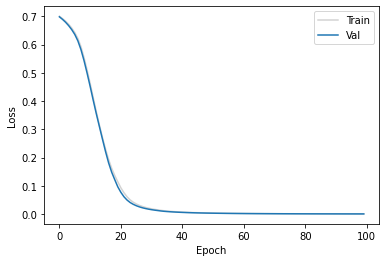

In [72]:
### MAIN ###
set_seed(seed=SEED)
model = Net_Task2(input_dimension = 2, output_dimension = 1)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
experiment = Experiment()
train = Training(model,optimizer,criterion)

print('\n The model parameters before the update are: \n')
print_params(model)

print("Size val_loader",len(val_loader))
print("Size train_loader",len(train_loader))

losses = []
val_losses = []
weee = Weights(model)
visu = Network_Visualization(display = True ,magnification=800,Model = model,input_size=2)



for epoch in range(n_epochs):
    loss = 0
    List_index_max= []
    List_index_min= []
    val_loss = 0 
    for x_batch, y_batch in train_loader:
        Loss,List_index_max,List_index_min = train.train_network(x_batch, y_batch,epoch)
        #print("List_index_max",List_index_max)
        #print("List_index_min",List_index_min)
        loss += Loss
        visu.draw(List_index_max,List_index_min)
        #list_index.append(List_index)
    losses.append(loss/len(train_loader))
    #print(list_index)
    
        
    with torch.no_grad():
        for x_val, y_val in val_loader:

            model.eval()

            yhat = model(x_val)
            val_loss += criterion( yhat,y_val.unsqueeze(1))
        val_losses.append(val_loss.item()/len(val_loader))





l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

plt.figure()
plt.plot(l_epoch,losses, '-', color='lightgrey', label='Train')
plt.plot(l_epoch_val,val_losses, '-', label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


